In [1]:
import pandas as pd
import numpy as np
import glob
list = []
files = glob.glob('datasets/text-files-to-mine/*.txt')

for names in files:
    f= open(names)
    contents = f.read().replace("\n"," ")
    list.append(contents)
    
ds = pd.Series(list)

In [2]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
stopwords = set(sw.words('english'))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [3]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(ds)

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

36360


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(ds)

    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(ds)

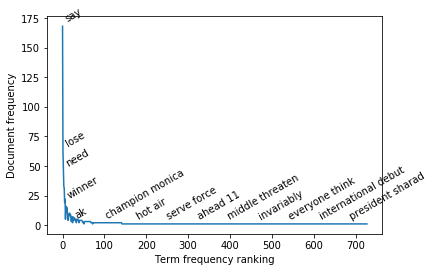

In [6]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

In [7]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 50% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.5)
X_filter = filter_vec.fit_transform(ds)

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

6904


In [8]:
terms = [{'term': t, 'idx': filter_vec.vocabulary_[t],
              'tf': X_filter[:, filter_vec.vocabulary_[t]].sum(),
              'df': X_filter[:, filter_vec.vocabulary_[t]].count_nonzero()}
             for t in filter_vec.vocabulary_]

In [9]:
# show the first fifteen high frequent terms
terms.sort(key=lambda x: (x['df']), reverse=True)
for x in terms[0:15]:
    print(x['term'])


last
would
world
first
get
come
back
player
also
second
give
old
team
three
new


In [10]:
from sklearn.cluster import KMeans

rs = 42
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X_filter)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

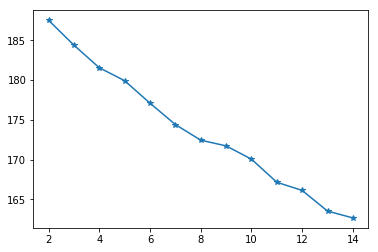

In [11]:
# plot the inertia vs K values
plt.plot(range(2, 15, 1), inertia_vals, marker='*')
plt.show()

In [12]:
from sklearn.metrics import silhouette_score

print(clusters[4])
print("Silhouette score for k=6", silhouette_score(X, clusters[4].predict(X_filter)))

print(clusters[5])
print("Silhouette score for k=7", silhouette_score(X, clusters[5].predict(X_filter)))

print(clusters[6])
print("Silhouette score for k=8", silhouette_score(X, clusters[6].predict(X_filter)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.013886875327546027
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=7 0.016236136435930363
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=8 0.016111941313355117


In [13]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)

CPU times: user 7.52 s, sys: 20.3 ms, total: 7.54 s
Wall time: 1.29 s


In [14]:
# visualisation
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: club, chelsea, player, want, arsenal, 
Top terms for cluster 1: indoor, world, olympic, record, 60m, 
Top terms for cluster 2: ball, england, wicket, day, vaughan, 
Top terms for cluster 3: open, 6, roddick, australian, 7, 
Top terms for cluster 4: marathon, race, paula, chepkemei, radcliffe, 
Top terms for cluster 5: drug, athletics, ban, test, athlete, 
Top terms for cluster 6: england, wale, rugby, nation, ireland, 


In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=rs)
X_trans = svd.fit_transform(X_filter)

In [16]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 england, 6, world, get, open, 
Top terms in component #1 6, open, 7, roddick, moya, 
Top terms in component #2 athens, athletics, race, world, marathon, 
Top terms in component #3 test, wicket, ball, pakistan, run, 
Top terms in component #4 ireland, wale, nation, england, six nation, 
Top terms in component #5 greek, drug, kenteris, test, open, 
Top terms in component #6 greek, arsenal, kenteris, drug, chelsea, 
Top terms in component #7 roddick, moya, davis, davis cup, england, 
Top terms in component #8 chepkemei, marathon, cross country, radcliffe, cross, 
Top terms in component #9 pakistan, moya, australia, shane, victory, 


In [17]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=7, random_state=42).fit(X_trans)

CPU times: user 260 ms, sys: 2.54 ms, total: 262 ms
Wall time: 46.3 ms


In [18]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: athletics, drug, ban, athlete, athens, 
Top terms for cluster 1: race, world, marathon, indoor, paula, 
Top terms for cluster 2: wale, williams, england, ireland, nation, 
Top terms for cluster 3: 6, roddick, open, 7, moya, 
Top terms for cluster 4: club, chelsea, arsenal, player, liverpool, 
Top terms for cluster 5: rugby, sri, england, tindall, new zealand, 
Top terms for cluster 6: cricket, ball, south, test, africa, 


#### 1. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

All 200 news stories in .txt format are read and placed into a pandas series. The text contents will be analysed.

#### 2. Can you identify data quality issues in order to perform text mining?

The original data are contents in text files which is unstructured, thus we need to transform the data to suitable structured data for text mining. We utilized the bag of words method in above. In the method, we transformed all letters to lowercased version, removed all punctuactions, filtered part of speed to only 4 types(none,verb,adj and adv), lemmatised words to their base forms and splited contents to tokens. Then, tokens of stopwords are removed as they are not valuable in analysis. Then, we transformed the tokens to metrics by TfidfVectorizer. 

#### 3. Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.

Say, Lose, Need which are too frequent and president shared, international debut, everyone think, invariably, middle threaten, ahead 11, serve force, hot air only appear once. 

#### 4. Did you disregard any frequent terms in addition to items automatically selected by the Filter tool?

Yes, such as 'say', 'lose' and 'need'. These terms are too frequent in texts and obviously invaluable in mining. 

#### 5. Justify the term weighting option selected.

We utilized TruncatedSVD which reduce the filtered X into only 100 components. It reduce the number of terms while preserving the similarity structure among documents.

#### 6. What is the number of input features available to execute clustering? (Hint: how the original text data is converted into a feature set that can be mined for knowledge discovery?)

6904, we removed terms which are too frequent and only appear once, these terms cannot add value for knowledge discovery.

#### 7. State how many clusters are generated? Name each cluster meaningfully according to the terms that appear in the clusters?

7 clusters, the number is found by elbow and silhouette score method. 

 0: illegal drugs in sports
 1: marathon
 2: nations
 3: tennis
 4: football clubs
 5: rugby
 6: cricket

#### 8. Identify the first fifteen high frequent terms (that are not stopwords or noise) in the start list?

last
would
world
first
get
come
back
player
also
second
give
old
team
three

#### 9. Describe how these clusters can be useful in the online personalised news story service planned by the news corporation.

For example, the news corporation can do clustering to the news stories that are viewed by a user and extract the themes of each cluster. Then they can send the news stories of these themes to the user more frequently.